In [1]:
import gym
import game

from ship_env import ShipEnv

from gym import wrappers, logger
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import cv2
import numpy as np

%matplotlib inline

ModuleNotFoundError: No module named 'game'

In [2]:
# Load up the ShipSim env
env = ShipEnv(speed=1, fps=10)

 *** SHIP-GYM INITIALIZED *** 


In [4]:
class FrameVideoWriter(object):
    
    def __init__(self, path, size, transform, fps=30):        
        fourcc = cv2.VideoWriter_fourcc(*'mpeg')
        self.vout = cv2.VideoWriter()
        self.size = size
        self.transform = transform
        self.vout.open(path,fourcc,fps,self.size,True)
             
    def write_frame(self, frame):
        cv2.resize(frame, self.size, interpolation=cv2.INTER_CUBIC)
        frame = self.transform(frame)
        self.vout.write(frame)
                  
    def finish(self):
        self.vout.release()
              
                       
transform = lambda f : cv2.rotate(f[...,::-1], cv2.ROTATE_90_CLOCKWISE)
fvw = FrameVideoWriter("forward.mp4", (128,128), transform, fps=30)
env.reset()

for _ in range(100):
    ret = env.step(0)
    frame = ret[0]
    fvw.write_frame(frame)   
    
fvw.finish()


print("Finished making video")

REACHED GOAL
COLLIDE WITH SHIP
COLLIDE WITH SHIP
COLLIDE WITH SHIP
Finished making video


reward =  -0.01


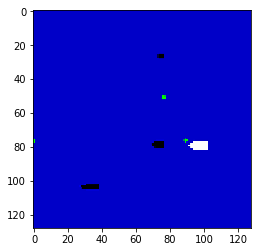

In [3]:
# Let's visualise a single step
env.reset()
ret = env.step(0)

# print(ret)
print("reward = ", ret[1])

cv2.imwrite("test.png", ret[0])
plt.imshow(ret[0])

In [5]:
class RandomAgent(object):
    """The world's simplest agent!"""
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done):
        return self.action_space.sample()

    
# You provide the directory to write to (can be an existing
# directory, including one with existing data -- all monitor files
# will be namespaced). You can also dump to a tempdir if you'd
# like: tempfile.mkdtemp().
outdir = '/tmp/random-agent-results'
env = ShipEnv(speed=1, fps=1)
env = wrappers.Monitor(env, directory=outdir, force=True)
env.seed(0)
agent = RandomAgent(env.action_space)

episode_count = 1
reward = 0
total_reward = 0
done = False

fvw = FrameVideoWriter("random_agent.mp4", (128, 128), transform, fps=30)

for i in range(episode_count):
    ob = env.reset()
    total_reward = 0
    
    print(f"Start Episode #{i}")
    while True:
        action = agent.act(ob, reward, done)
        ob, reward, done, _ = env.step(action)
        total_reward += reward
        print(".", end="")
        if done:
            print("Episode finished.")
            print("Final Reward = ", total_reward)
            break

#         print(ob.shape)
        fvw.write_frame(ob)
        
        # Note there's no env.render() here. But the environment still can open window and
        # render if asked by env.monitor: it calls env.render('rgb_array') to record video.
        # Video is not recorded every episode, see capped_cubic_video_schedule for details.

# Close the env and write monitor result info to disk
env.close()
fvw.finish()

 *** SHIP-GYM INITIALIZED *** 
WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
Start Episode #0
..................REACHED GOAL
.................................................COLLIDE WITH SHIP
........COLLIDE WITH SHIP
.........COLLIDE WITH SHIP
...................COLLIDE WITH SHIP
..........COLLIDE WITH SHIP
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [6]:
# What if we use a smarter agent ...?

# Baselines contains implementations of all the common RL algorithms ..

#!/usr/bin/env python3

from mpi4py import MPI
from baselines.common import set_global_seeds
from baselines import bench
import os.path as osp
from baselines import logger
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
from baselines.common.cmd_util import atari_arg_parser

def train(num_timesteps, seed):
    from baselines.ppo1 import pposgd_simple, cnn_policy
    import baselines.common.tf_util as U
    
    rank = MPI.COMM_WORLD.Get_rank()
    sess = U.single_threaded_session()
    sess.__enter__()
    if rank == 0:
        logger.configure()
    else:
        logger.configure(format_strs=[])
    workerseed = seed + 10000 * MPI.COMM_WORLD.Get_rank() if seed is not None else None
    set_global_seeds(workerseed)
    
    def policy_fn(name, ob_space, ac_space): #pylint: disable=W0613
        return cnn_policy.CnnPolicy(name=name, ob_space=ob_space, ac_space=ac_space)

    env = ShipEnv(speed=1, fps=10)
    env = bench.Monitor(env, logger.get_dir() and
        osp.join(logger.get_dir(), str(rank)))
    env.seed(workerseed)

#     env = wrap_deepmind(env)
#     env.seed(workerseed)

    pposgd_simple.learn(env, policy_fn,
        max_timesteps=int(num_timesteps * 1.1),
        timesteps_per_actorbatch=256,
        clip_param=0.2, entcoeff=0.01,
        optim_epochs=4, optim_stepsize=1e-3, optim_batchsize=64,
        gamma=0.99, lam=0.95,
        schedule='linear'
    )
    env.close()

def main():
    train(1000, 0)

main()


/Users/gerard/.virtualenvs/ship-gym/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Logging to /var/folders/p5/vlbb7n216ydgw5ygyz0r0qgw0000gn/T/openai-2018-09-08-13-18-27-804071
 *** SHIP-GYM INITIALIZED *** 
(?, 128, 128, 3)
(?, 31, 31, 32)
(?, 14, 14, 64)
(?, 128, 128, 3)
(?, 31, 31, 32)
(?, 14, 14, 64)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

********** Iteration 0 ************
{}


KeyError: None